# Code for creating annotated spirals

Here I will prepare functions that will enable generation of all types of spirals, but unified annotation to be used in transformer training. Annotation template (T - number of thetas):<br>
```python
spiral = {
    "theta":                theta,         # [T] angles
    "r":                    r,             # [T] radius
    "type_labels":          type_labels,   # [T] ints in {0: "normal", 1: "flat", 2: "tight"}
    # "flattness_severity":   severity,      # [T] floats
    "tightness_severity":   severity,      # [T] floats 
    "params":               (start_angle, end_angle, k),  # [3]
}
```

**Imports:**

In [176]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter

**Support functions:**

In [2]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

def archimedas_spiral(theta_range, a0, granularity=500):
    theta = np.linspace(theta_range[0], theta_range[1], granularity)
    arch_x = a0*theta*np.cos(theta)
    arch_y = a0*theta*np.sin(theta)
    
    return (arch_x,arch_y)

def archimedas_descriptor(theta_range, a0, granularity=500):
    arch = archimedas_spiral(theta_range, a0, granularity)
    
    arch_traj = resample_trajectory([(x,y) for x,y in zip(arch[0],arch[1])],M)
    Z_archimedes = fourier_descriptor_transform(arch_traj)
    
    return Z_archimedes

def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()

    return ax1, ax2

def apply_local_shaping(r_data, theta_data, local_minimas_theta, local_minimas_r, 
                        local_maximas_theta, local_maximas_r, tightness_width, flat_precentage):
    """
    Applies local shaping (tightening for minimas, loosening for maximas) to the radial data.

    Args:
        r_data (np.ndarray): The radial data array to be modified.
        theta_data (np.ndarray): The corresponding angular data array.
        local_minimas_theta (np.ndarray): Angles of local minimas.
        local_minimas_r (np.ndarray): Radius of local minimas.
        local_maximas_theta (np.ndarray): Angles of local maximas.
        local_maximas_r (np.ndarray): Radii of local maximas.
        tightness_width (float): The total angular width of the shaping window.
        flat_precentage (float): The percentage of the width that will be flat (0 to 1).

    Returns:
        np.ndarray: The modified radial data array.
    """
    
    # Create a copy of the radial data to modify
    r_shaped = r_data.copy()
    
    HALF_FLAT_WIDTH = (tightness_width * flat_precentage) / 2
    
    # Combine minimas and maximas into a list of tasks
    # Each task is (theta_list, r_list, application_function)
    tasks = [
        (local_minimas_theta, local_minimas_r, np.minimum),  # Minimas: Use np.minimum to pull down
        (local_maximas_theta, local_maximas_r, np.maximum)   # Maximas: Use np.maximum to push up
    ]
    
    # Process both minimas and maximas in a single loop structure
    for lt_thetas, lt_rs, application_func in tasks:
        
        if len(lt_thetas) == 0:
            continue

        for i in range(len(lt_thetas)):
            lt_theta = lt_thetas[i]
            lt_r = lt_rs[i]
            
            # 1. Define the full angular window (W)
            full_start_angle = lt_theta - tightness_width / 2
            full_end_angle = lt_theta + tightness_width / 2
            
            # 2. Define the FLAT region boundaries (F)
            flat_start_angle = lt_theta - HALF_FLAT_WIDTH
            flat_end_angle = lt_theta + HALF_FLAT_WIDTH
            
            # 3. Get the radius at the edges of the full window from the CURRENT r_shaped array
            # These are the points the ramps connect *to*.
            # Use theta_data for the x-axis and r_shaped for the y-axis (the current curve)
            r_at_start = np.interp(full_start_angle, theta_data, r_shaped)
            r_at_end = np.interp(full_end_angle, theta_data, r_shaped)
            
            # 4. Initialize the target radius array for the entire window
            mask_full = (theta_data >= full_start_angle) & (theta_data <= full_end_angle)
            theta_segment = theta_data[mask_full]
            r_target_segment = np.empty_like(theta_segment)
            
            # --- A. Flat Central Region ---
            mask_flat = (theta_segment >= flat_start_angle) & (theta_segment <= flat_end_angle)
            r_target_segment[mask_flat] = lt_r
            
            # --- B. Left Ramp Region ---
            mask_left = theta_segment < flat_start_angle
            theta_left = theta_segment[mask_left]
            
            # Ramp connects r_at_start (at full_start_angle) to lt_r (at flat_start_angle)
            denominator_left = flat_start_angle - full_start_angle
            
            if denominator_left > 1e-9: 
                # Formula: r = r_start + (r_end - r_start) * ( (theta - theta_start) / (theta_end - theta_start) )
                r_target_left = r_at_start + (lt_r - r_at_start) * (
                    (theta_left - full_start_angle) / denominator_left
                )
            else: 
                r_target_left = np.full_like(theta_left, lt_r)

            r_target_segment[mask_left] = r_target_left
            
            # --- C. Right Ramp Region ---
            mask_right = theta_segment > flat_end_angle
            theta_right = theta_segment[mask_right]

            # Ramp connects lt_r (at flat_end_angle) to r_at_end (at full_end_angle)
            denominator_right = full_end_angle - flat_end_angle
            
            if denominator_right > 1e-9: 
                # Formula: r = r_start + (r_end - r_start) * ( (theta - theta_start) / (theta_end - theta_start) )
                r_target_right = lt_r + (r_at_end - lt_r) * (
                    (theta_right - flat_end_angle) / denominator_right
                )
            else: 
                r_target_right = np.full_like(theta_right, lt_r)
                
            r_target_segment[mask_right] = r_target_right
            
            # 5. Apply the shaping: use the stored application_func (np.minimum for minimas, np.maximum for maximas)
            r_shaped[mask_full] = application_func(r_shaped[mask_full], r_target_segment)
            
    return r_shaped

## Per class functions

In [373]:
def generate_spiral_dict(total_steps):
    """Return a default spiral dictionary with zeroed severity and type labels."""
    return {
        'theta': None,
        'r': None,
        'type_labels': total_steps * [0],
        'tightness_severity': total_steps * [0],
        'params': (None, None, None)
    }

**Archimedes spiral:**

In [5]:
def generate_archimedes(spiral_params):
    
    theta_start = spiral_params['theta_start']
    theta_end = spiral_params['theta_end']
    k = spiral_params['k']
    steps_per_rotation = spiral_params['steps_per_rotation']
    
    total_steps = int((theta_end - theta_start) / (2 * np.pi) * steps_per_rotation)
    spiral_dict = generate_spiral_dict(total_steps)
    
    theta = np.linspace(theta_start, theta_end, total_steps)
    r = k * theta
    
    spiral_dict['theta'] = theta
    spiral_dict['r'] = r
    spiral_dict['params'] = (theta_start, theta_end, k)
    
    return spiral_dict

**Tight spiral:**

In [6]:
def generate_tight(spiral_params, tight_params, sigma=10.0, radius=6):
    
    # Archimedes spiral base
    theta_start = spiral_params['theta_start']
    theta_end = spiral_params['theta_end']
    k = spiral_params['k']
    steps_per_rotation = spiral_params['steps_per_rotation']
    
    total_steps = int((theta_end - theta_start) / (2 * np.pi) * steps_per_rotation)
    spiral_dict = generate_spiral_dict(total_steps)
    
    theta = np.linspace(theta_start, theta_end, total_steps)
    r = k * theta
    
    spiral_dict['theta'] = theta
    spiral_dict['params'] = (theta_start, theta_end, k)

    max_r = np.max(r)

    # Tightening parameters
    tightness_angle = tight_params['tight_angle']
    n_ratio = tight_params['n_ratio']
    max_k2k_ratio = tight_params['max_k2k_ratio']
    tightness_k = np.min([tight_params['tight_k'], max_k2k_ratio * k])
    tightness_width =  tight_params['tight_width_ratio'] * max_r
    
    def get_local_minimas(tightness_angle, tightness_k, n_ratio, max_r, theta_end):
        """Function that computes  the local minimas positions (theta, r) for tightening."""
        local_minimas_theta = []
        local_minimas_r = []
        minima_theta = tightness_angle
        while minima_theta < theta_end + 2*np.pi:
            local_minimas_theta.append(minima_theta)
            local_minimas_r.append(tightness_k * minima_theta + n_ratio * max_r)
            minima_theta += 2*np.pi
        local_minimas_theta = np.array(local_minimas_theta)
        local_minimas_r = np.array(local_minimas_r)
        
        return local_minimas_theta, local_minimas_r
    
    minimas_theta, minimas_r = get_local_minimas(tightness_angle, tightness_k, n_ratio, max_r, theta_end) 

    r_tightened = r.copy()
    r_tightened = apply_local_shaping(r_tightened, theta, minimas_theta, minimas_r, [], [], tightness_width, tight_params['flat_precentage'])
    r_tightened = gaussian_filter(r_tightened, sigma=sigma, mode='nearest', radius=radius)
    
    spiral_dict['r'] = r_tightened
    r_diff = list(np.abs(r - r_tightened))
    spiral_dict['tightness_severity'] = (r_diff / r) * (k / tightness_k)
    spiral_dict['type_labels'] = [2 if rd > r * 0.1 else 0 for r, rd in zip(r, r_diff)]
    
    return spiral_dict

In [459]:
def plot_tight(spiral_dict):
    theta = np.asarray(spiral_dict['theta'])
    r = np.asarray(spiral_dict['r'])
    type_labels = np.asarray(spiral_dict['type_labels'])
    tightness_severity = np.asarray(spiral_dict['tightness_severity'])
    start_angle, end_angle, k = spiral_dict['params']

    # --- Base spiral from params (adjust formula if needed) ---
    # Example: Archimedean-like: r = k * theta
    r_base = k * theta

    # Masks for types
    normal_mask = (type_labels == 0)
    flat_mask   = (type_labels == 1)
    tight_mask  = (type_labels == 2)

    # Shared color scaling for severity
    vmin = float(np.nanmin(tightness_severity))
    vmax_raw = float(np.nanmax(tightness_severity))
    vmax = vmax_raw if vmax_raw > vmin else vmin + 1e-6
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = 'plasma'

    fig, (ax1, ax_dummy) = plt.subplots(
        1, 2, figsize=(14, 6),
        gridspec_kw={'wspace': 0.2}
    )
    # Replace second axes with polar
    ax2 = fig.add_subplot(1, 2, 2, projection='polar')

    # ===================== CARTESIAN: Radius vs Theta =====================
    unwrapped_theta = np.unwrap(theta)

    # Base spiral in background (light gray)
    ax1.plot(
        unwrapped_theta,
        r_base,
        color='lightgray',
        linewidth=1.5,
        zorder=1,
        label='Base spiral'
    )

    # Normal points (circle)
    if normal_mask.any():
        ax1.scatter(
            unwrapped_theta[normal_mask],
            r[normal_mask],
            c=tightness_severity[normal_mask],
            cmap=cmap,
            norm=norm,
            marker='o',
            s=7,
            zorder=2
        )

    # Flat points ('_' marker)
    if flat_mask.any():
        ax1.scatter(
            unwrapped_theta[flat_mask],
            r[flat_mask],
            c=tightness_severity[flat_mask],
            cmap=cmap,
            norm=norm,
            marker='_',
            s=20,
            zorder=2
        )

    # Tight points ('+' marker)
    if tight_mask.any():
        ax1.scatter(
            unwrapped_theta[tight_mask],
            r[tight_mask],
            c=tightness_severity[tight_mask],
            cmap=cmap,
            norm=norm,
            marker='+',
            s=20,
            zorder=2
        )

    # Proper colorbar for tightness severity (cartesian)
    sm1 = ScalarMappable(norm=norm, cmap=cmap)
    sm1.set_array([])  # needed for older matplotlib
    cbar1 = plt.colorbar(sm1, ax=ax1)
    cbar1.set_label('Tightness Severity')

    ax1.set_title("Radius vs Theta")
    ax1.grid(True)

    theta_end = int(theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Legend for types (marker shape only; color is severity)
    legend_elements = [
        Line2D([0], [0], marker='o', linestyle='None', color='black', label='Normal'),
        Line2D([0], [0], marker='+', linestyle='None', color='black', markersize=10, label='Tight Segment'),
    ]
    ax1.legend(handles=legend_elements, title="Type", loc="best")

    # ========================= POLAR: Spiral =========================
    # Base spiral in background
    ax2.plot(
        theta,
        r_base,
        color='lightgray',
        linewidth=1.5,
        zorder=1
    )

    # Normal points
    if normal_mask.any():
        ax2.scatter(
            theta[normal_mask],
            r[normal_mask],
            c=tightness_severity[normal_mask],
            cmap=cmap,
            norm=norm,
            marker='o',
            s=15,
            zorder=2
        )

    # Flat points
    if flat_mask.any():
        ax2.scatter(
            theta[flat_mask],
            r[flat_mask],
            c=tightness_severity[flat_mask],
            cmap=cmap,
            norm=norm,
            marker='_',
            s=40,
            zorder=2
        )

    # Tight points
    if tight_mask.any():
        ax2.scatter(
            theta[tight_mask],
            r[tight_mask],
            c=tightness_severity[tight_mask],
            cmap=cmap,
            norm=norm,
            marker='+',
            s=40,
            zorder=2
        )

    # Proper colorbar for tightness severity (polar)
    sm2 = ScalarMappable(norm=norm, cmap=cmap)
    sm2.set_array([])
    cbar2 = plt.colorbar(sm2, ax=ax2)
    cbar2.set_label('Tightness Severity')

    ax2.set_title("Tightened Spiral")
    for spine in ax2.spines.values():
        spine.set_visible(False)
        
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.axis('off')
    
    ax_dummy.remove()

    plt.suptitle("Spiral with Local Tightening")
    plt.show()

**Flat spiral:**

In [322]:
def check_for_intersections(theta, r):
    """
    Checks for self-intersection in a polar curve (r, theta) over a 2*pi rotation.
    Self-intersection occurs if r(theta + 2*pi) < r(theta).
    
    Args:
        theta (np.ndarray): Array of angles (must span at least 2*pi).
        r (np.ndarray): Array of radii.

    Returns:
        bool: True if self-intersection is detected, False otherwise.
    """
    
    # 1. Ensure theta is sorted (required for np.interp)
    # This is generally true for spiral generation, but good practice.
    sort_indices = np.argsort(theta)
    theta_sorted = theta[sort_indices]
    r_sorted = r[sort_indices]

    # 2. Iterate only over the angles where theta + 2*pi is still within the domain
    # This optimization avoids unnecessary checks and handles bounds better.
    theta_limit = theta_sorted[-1] - 2 * np.pi
    
    # Use a mask to get the angles in the current domain (theta) that are also in the 
    # range [theta_start, theta_end - 2*pi]
    mask = theta_sorted <= theta_limit
    theta_current = theta_sorted[mask]
    r_current = r_sorted[mask]

    # 3. Use NumPy's highly efficient np.interp to find r(theta + 2*pi)
    # The 'theta_current + 2 * np.pi' array serves as the x-coordinates to interpolate.
    theta_plus_2pi = theta_current + 2 * np.pi
    
    # r_plus_2pi is the interpolated radius at the next rotation
    r_plus_2pi = np.interp(theta_plus_2pi, theta_sorted, r_sorted)

    # 4. Check the condition for self-intersection across all relevant points
    # Intersection occurs if the radius is decreasing too fast: r(theta + 2pi) < r(theta)
    # if np.any(r_plus_2pi < r_current):
    #     return True
    
    # return False 
    
    return np.sum(r_plus_2pi < r_current)

In [374]:
def generate_flat(spiral_params, flat_params, type="insert_line", sigma_ins=2.0, radius_ins=2, sigma_ext=20.0, radius_ext=1):
    
    # Archimedes spiral base
    theta_start = spiral_params['theta_start']
    theta_end = spiral_params['theta_end']
    k = spiral_params['k']
    steps_per_rotation = spiral_params['steps_per_rotation']
    
    total_steps = int((theta_end - theta_start) / (2 * np.pi) * steps_per_rotation)
    spiral_dict = generate_spiral_dict(total_steps)
    
    theta = np.linspace(theta_start, theta_end, total_steps)
    r = k * theta
    
    spiral_dict['theta'] = theta
    spiral_dict['params'] = (theta_start, theta_end, k)
    
    def insert_flat2radius(_theta, _r, start_idx, end_idx, start_point, end_point):
        """Calculate new radius values for points between start_idx and end_idx that form a straight line connecting start and end point"""
        modified_r = _r.copy()
        
        for ang_idx in range(start_idx, end_idx):
            ang = _theta[ang_idx]
            t = (np.tan(ang) * start_point[0] - start_point[1]) / (end_point[1] - start_point[1] - np.tan(ang) * (end_point[0] - start_point[0]))
            x = start_point[0] + t * (end_point[0] - start_point[0])
            y = start_point[1] + t * (end_point[1] - start_point[1])
            
            r_temp = np.sqrt(x**2 + y**2)
            modified_r[ang_idx] = r_temp
            
        return modified_r
    
    # OPTION 1 - Insert line segment
    def insert_line_segment(_theta, _r, _start_ang, _flat_len_rad):
        start_angle, end_angle = _start_ang, _start_ang + _flat_len_rad # Define flat segment angles
        start_idx = np.argmin(abs(theta - start_angle))
        end_idx = np.argmin(abs(theta - end_angle))
        
        start_ang, end_ang = _theta[start_idx], _theta[end_idx] # Exact angles that exist in _theta
        start_r, end_r = _r[start_idx], _r[start_idx]           # Corresponding radius values
        
        start_point = start_r * np.cos(start_ang), start_r * np.sin(start_ang)  # Cartesian coords
        end_point = end_r * np.cos(end_ang), end_r * np.sin(end_ang)            # Cartesian coords
        
        modified_r = insert_flat2radius(_theta, _r, start_idx + 1, end_idx, start_point, end_point)
        
        return modified_r, start_idx, end_idx
    
    # OPTION 2 - Extended flat regions
    def extend_radius_region(_theta, _r, mid_angle, start_offset, end_offset, displacement_fac_r, displacement_fac_len):
        mid_idx = np.argmin(abs(_theta - mid_angle))
        start_idx = np.argmin(abs(_theta - (mid_angle - start_offset)))
        mid_ang = _theta[mid_idx]
        start_ang = _theta[start_idx]
        mid_r = _r[mid_idx] * (1 + displacement_fac_r) # Displace radius at mid point
        start_r = _r[start_idx]
        
        mid_point = mid_r * np.cos(mid_ang), mid_r * np.sin(mid_ang)            # Cartesian coords
        start_point = start_r * np.cos(start_ang), start_r * np.sin(start_ang)  # Cartesian coords

        def unfold_angle(angle, _mid_ang):
            if angle < 0: angle += 2 * np.pi
            while angle < _mid_ang:
                angle += 2 * np.pi
            return angle

        # Determine the end point of the extended line segment
        end_point_x = mid_point[0] + (mid_point[0] - start_point[0]) * displacement_fac_len # Extend line segment
        end_point_y = mid_point[1] + (mid_point[1] - start_point[1]) * displacement_fac_len # Extend line segment
        end_point = (end_point_x, end_point_y)
        
        end_ang = np.arctan2(end_point[1], end_point[0])
        end_ang = unfold_angle(end_ang, mid_ang)
        end_idx = np.argmin(abs(_theta - end_ang))
        
        # Determine the fourth point (where segments meets the spiral again)
        fourth_angle = end_ang + end_offset
        fourth_idx = np.argmin(abs(_theta - fourth_angle))
        fourth_ang = _theta[fourth_idx]
        fourth_r = _r[fourth_idx]
        fourth_point = fourth_r * np.cos(fourth_ang), fourth_r * np.sin(fourth_ang)

        # Insert the line segment
        modified_r = insert_flat2radius(_theta, _r, start_idx + 1, end_idx, start_point, end_point)
        modified_r = insert_flat2radius(_theta, modified_r, end_idx, fourth_idx, end_point, fourth_point)
        
        return modified_r, start_idx, fourth_idx
        
    # Process flat segments
    insertions = flat_params['insertions']
    for ins in insertions:
        r, start, end = insert_line_segment(theta, r, ins['ins_angle'], ins['ins_len'])
        spiral_dict['type_labels'][start:end] = [1]*(end-start) # Mark as flat segment
    r = gaussian_filter(r, sigma=sigma_ins, mode='nearest', radius=radius_ins)
    
    extensions = flat_params['extensions']
    for ext in extensions:
        r, start, end = extend_radius_region(
            theta, r,
            ext['mid_angle'],
            ext['start_offset'],
            ext['end_offset'],
            ext['displacement_fac_r'],
            ext['displacement_fac_len']
        )
        spiral_dict['type_labels'][start:end] = [1]*(end-start) # Mark as flat segment
    r = gaussian_filter(r, sigma=sigma_ext, mode='nearest', radius=radius_ext)
    
    spiral_dict['r'] = r
    
    return spiral_dict

In [460]:
def plot_flat(spiral_dict):
    theta = np.asarray(spiral_dict['theta'])
    r = np.asarray(spiral_dict['r'])
    type_labels = np.asarray(spiral_dict['type_labels'])  # should be all 1
    start_angle, end_angle, k = spiral_dict['params']

    # Base spiral
    r_base = k * theta

    # Mask: flat only
    flat_mask = (type_labels == 1)

    fig, (ax1, ax_dummy) = plt.subplots(
        1, 2, figsize=(14, 6),
        gridspec_kw={'wspace': 0.2}
    )
    ax2 = fig.add_subplot(1, 2, 2, projection='polar')

    # ========================= CARTESIAN =========================
    unwrapped_theta = np.unwrap(theta)

    # Base spiral
    ax1.plot(
        unwrapped_theta,
        r_base,
        color='lightgray',
        linewidth=1.5,
        zorder=1,
        label='Base spiral'
    )
    
    ax1.scatter(
        unwrapped_theta[~flat_mask],
        r[~flat_mask],
        color='navy',
        linewidth=1.5,
        zorder=2,
        s=7,
        marker='o',
        alpha=0.5,
        label='Base spiral'
    )
    

    # Flat points (blue)
    ax1.scatter(
        unwrapped_theta[flat_mask],
        r[flat_mask],
        color='deepskyblue',
        marker='+',
        s=20,
        linewidths=2.0,
        zorder=3,
        label='flat'
    )

    ax1.set_title("Radius vs Theta (Flat Spiral)")
    ax1.grid(True)

    # π ticks
    theta_end = int(theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f"{i}π" for i in range(theta_end + 1)]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels)

    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', linestyle='None', color='navy', label='Normal'),
        Line2D([0], [0], marker='+', linestyle='None', color='deepskyblue',
               markersize=10, label='Flat segment'),
    ]
    ax1.legend(handles=legend_elements, title="Type", loc="best")

    # ============================ POLAR ============================
    ax2.plot(
        theta,
        r_base,
        color='lightgray',
        linewidth=1.5,
        zorder=1
    )
    
    ax2.scatter(
        theta[~flat_mask],
        r[~flat_mask],
        color='navy',
        marker='o',
        s=7,
        alpha=0.5,
        linewidths=2.0,
        zorder=2
    )

    ax2.scatter(
        theta[flat_mask],
        r[flat_mask],
        color='deepskyblue',
        
        marker='+',
        s=40,
        linewidths=2.0,
        zorder=3
    )

    ax2.set_title("Flat Spiral")

    # Hide everything except points
    for spine in ax2.spines.values():
        spine.set_visible(False)
        
    ax2.legend(handles=legend_elements, title="Type", loc="best")
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.axis('off')

    ax_dummy.remove()

    plt.suptitle("Spiral with Local Flattening")
    plt.show()

In [415]:
def generete_flat_params(spiral_params, flat_params_input):
    
    flat_params = flat_params_input.copy()
    flat_params['insertions'] = []
    flat_params['extensions'] = []
    
    max_ins_per_rotation = flat_params['max_ins_per_rotation']
    max_ext_per_rotation = flat_params['max_ext_per_rotation']
    ins_len_range = flat_params['ins_len_range']
    start_offset_range = flat_params['start_offset_range']
    end_offset_range = flat_params['end_offset_range']
    disp_fac_r_range = flat_params['disp_fac_r_range']
    disp_fac_len_range = flat_params['disp_fac_len_range']
    
    num_rotations = (spiral_params['theta_end'] - spiral_params['theta_start']) / (2 * np.pi)
    num_insertions = np.random.randint(1, max(2, int(max_ins_per_rotation * num_rotations)))
    num_extensions = np.random.randint(0, max(1, int(max_ext_per_rotation * num_rotations)))
    
    def sample_with_min_distance(a, b, n, r, pts=None, max_att = 10000):
        """Sample n points in [a, b] such that any two points are at least r apart."""
        
        if pts is not None:
            points = pts.copy()
        points = []
        attempts = 0
        max_attempts = max_att

        while len(points) < n and attempts < max_attempts:
            x = random.uniform(a, b)
            if all(abs(x - p) >= r for p in points):
                points.append(x)
            attempts += 1

        if len(points) < n:
            raise RuntimeError("Could not place all points; reduce n or r.")
        return sorted(points)
    
    insertion_angles = sample_with_min_distance(spiral_params['theta_start'] + 2*np.pi, spiral_params['theta_end'], num_insertions, 0.5*np.pi)
    extension_angles = sample_with_min_distance(spiral_params['theta_start'] + 2*np.pi, spiral_params['theta_end'], num_extensions, 0.5*np.pi, pts=insertion_angles)
    
    for ang in insertion_angles:
        insertion = {
            "ins_angle": ang,
            "ins_len": np.random.uniform(ins_len_range[0], ins_len_range[1])
        }
        flat_params['insertions'].append(insertion)
        
    for ang in extension_angles:
        extension = {
            "mid_angle": ang,
            "start_offset": np.random.uniform(start_offset_range[0], start_offset_range[1]),
            "end_offset": np.random.uniform(end_offset_range[0], end_offset_range[1]),
            "displacement_fac_r": np.random.uniform(disp_fac_r_range[0], disp_fac_r_range[1]),
            "displacement_fac_len": np.random.uniform(disp_fac_len_range[0], disp_fac_len_range[1])
        }
        flat_params['extensions'].append(extension)
    
    return flat_params

### Testing the functions

Number of self-intersections detected: 0
Number of insertions: 1
Number of extensions: 0
Number of self-intersections detected: 0


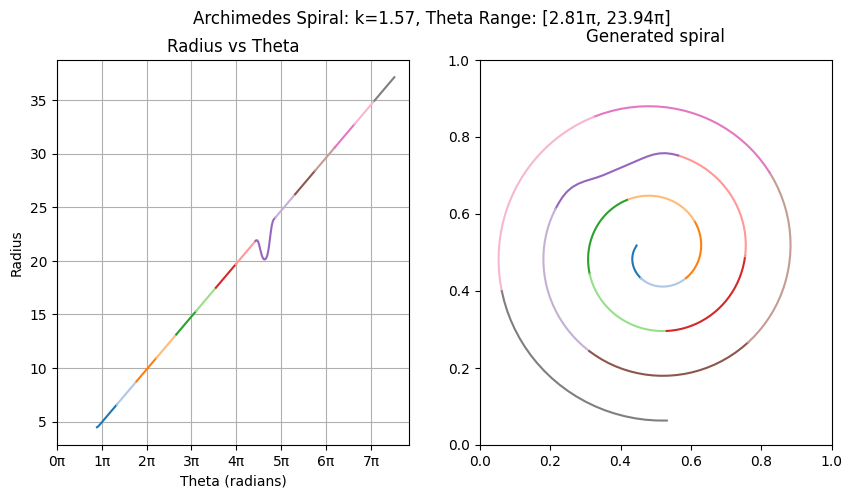

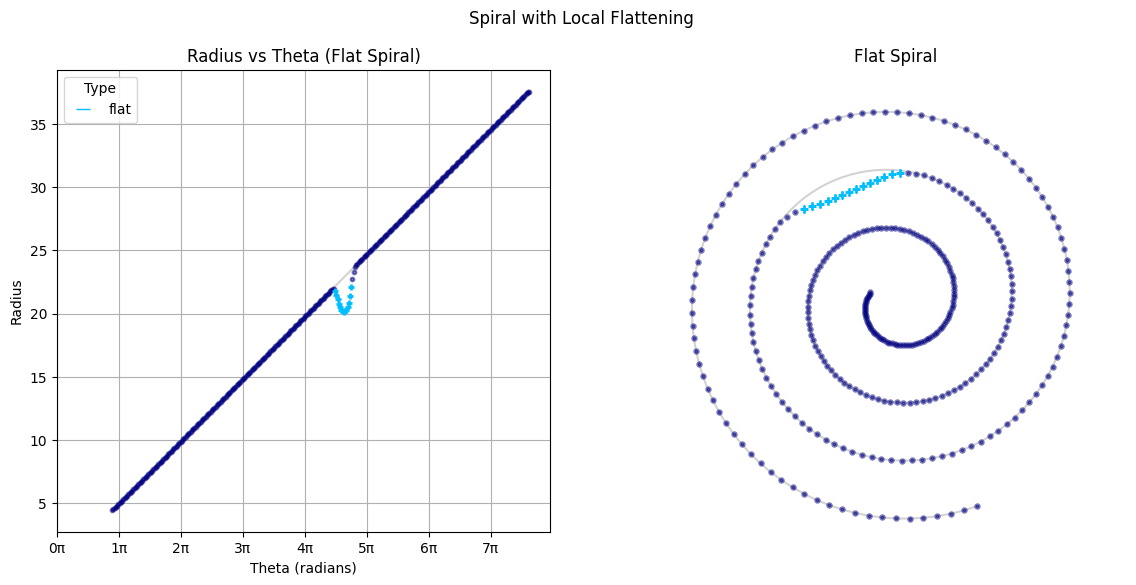

In [444]:
## General parameters
STEPS_PER_ROTATION = 100                    # Number of steps per full rotation (2*pi) 
MIN_THETA_RANGE = (0, np.pi)                # Start theta angle range for spiral generation
MAX_THETA_RANGE = (6*np.pi, 12*np.pi)       # End theta angle range for spiral generation
K_RANGE = (0.5, 2.0)                        # Range for spiral growth rate

## Tightness parameters
N_RATIO_RANGE = (0.0, 0.02)                 # Ratio of n parameter for linear equation in terms of max radius
TIGHT_K_RANGE = (0.4, 1.3)                  # Range for tightness_k parameter for spiral growth rate
TIGHT_WIDTH_RATIO_RANGE = (0.1, 0.14)       # Ratio of width of tightness to max radius
MAX_K2K_RATIO = 0.45                        # Max ratio of tightness_k to original k
FLAT_PERCENTAGE = 0.3                       # Percentage of flat region in tightness window

## Flatness parameters
MAX_INS_PER_ROTATION = 1                    # Max number of insertions per full rotation
MAX_EXT_PER_ROTATION = 0.8                  # Max number of extensions per full rotation
INS_LEN_RANGE = (0.2*np.pi, 0.55*np.pi)     # Range for insertion length in radians
START_OFFSET_RANGE = (0.1*np.pi, 0.5*np.pi) # Range for extension start offset in radians
END_OFFSET_RANGE = (0.1*np.pi, 0.5*np.pi)   # Range for extension end offset in radians
DISP_FAC_R_RANGE = (0.003, 0.02)            # Range for displacement factor for radius
DISP_FAC_LEN_RANGE = (0.2, 1.05)            # Range for displacement factor for length

flat_params_deafult = {
    "insertions": [],
    "extensions": [],
    "max_ins_per_rotation": MAX_INS_PER_ROTATION,
    "max_ext_per_rotation": MAX_EXT_PER_ROTATION,
    "ins_len_range": INS_LEN_RANGE,
    "start_offset_range": START_OFFSET_RANGE,
    "end_offset_range": END_OFFSET_RANGE,
    "disp_fac_r_range": DISP_FAC_R_RANGE,
    "disp_fac_len_range": DISP_FAC_LEN_RANGE
}

spiral_params = {
    'steps_per_rotation': STEPS_PER_ROTATION,
    'theta_start': np.random.uniform(MIN_THETA_RANGE[0], MIN_THETA_RANGE[1]),
    'theta_end': np.random.uniform(MAX_THETA_RANGE[0], MAX_THETA_RANGE[1]),
    'k': np.random.uniform(K_RANGE[0], K_RANGE[1])
}

tight_params = {
    "tight_angle": np.random.uniform(0, 2*np.pi),
    "n_ratio" :  np.random.uniform(N_RATIO_RANGE[0], N_RATIO_RANGE[1]),
    "tight_k":  np.random.uniform(TIGHT_K_RANGE[0], TIGHT_K_RANGE[1]),
    "tight_width_ratio": np.random.uniform(TIGHT_WIDTH_RATIO_RANGE[0], TIGHT_WIDTH_RATIO_RANGE[1]),
    "max_k2k_ratio": MAX_K2K_RATIO,
    "flat_precentage": FLAT_PERCENTAGE
}

# spiral_dict = generate_archimedes(spiral_params)
# spiral_dict = generate_tight(spiral_params, tight_params)
while True:
    flat_params = generete_flat_params(spiral_params, flat_params_deafult)
    spiral_dict = generate_flat(spiral_params, flat_params)
    num_of_intrsections = check_for_intersections(spiral_dict['theta'], spiral_dict['r'])
    print("Number of self-intersections detected:", num_of_intrsections)
    if num_of_intrsections <= 8:
        break

# flat_params = generete_flat_params(spiral_params, flat_params_deafult.copy())
# spiral_dict = generate_flat(spiral_params, flat_params)

# Plotting
plot_theta = spiral_dict['theta']
plot_r = spiral_dict['r']

fig, axes = plt.subplots(1,2,figsize=(10,5))
ax1 = axes[0]
ax2 = fig.add_subplot(1, 2, 2, projection='polar')

num_of_intrsections = check_for_intersections(plot_theta, plot_r)

print("Number of insertions:", len(flat_params['insertions']))
print("Number of extensions:", len(flat_params['extensions']))
print("Number of self-intersections detected:", num_of_intrsections)

ax1, ax2 = plot_segmented_spiral(
    gen_theta=plot_theta,
    gen_r=plot_r,
    num_segments=15,
    num_points=len(plot_theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Archimedes Spiral: k={spiral_params['k']:.2f}, Theta Range: [{spiral_params['theta_start']:.2f}π, {spiral_params['theta_end']:.2f}π]",
    axes=(ax1,ax2)
)

# plot_tight(spiral_dict)
plot_flat(spiral_dict)
plt.show()

## Loading the results

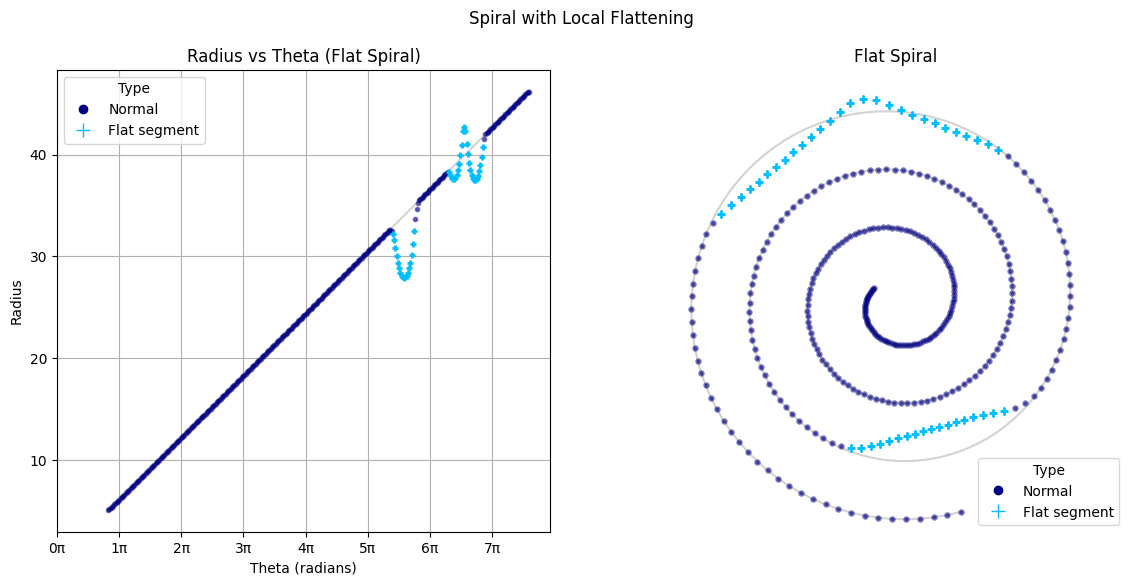

In [462]:
data = np.load("normal/flat_0.npz")
spiral_dict = {
    "theta": data["theta"],
    "r": data["r"],
    "type_labels": data["type_labels"],
    "tightness_severity": data["tightness_severity"],
    "params": data["params"]
}

#plot_tight(spiral_dict)
plot_flat(spiral_dict)
plt.show()

## Plotting

In [1032]:
directory = "syn_data/"
sub_directories = ["archimedes/", "flat/", "spiky/", "tight/"]
filenames = ["archimedes_spiral_", "flat_spiral_", "spiky_spiral_", "tight_spiral_"]
num2plot = 2
indices = {
    "archimedes": np.random.randint(0, 1000, size=num2plot),
    "flat": np.random.randint(0, 1000, size=num2plot),
    "spiky": np.random.randint(0, 1000, size=num2plot),
    "tight": np.random.randint(0, 1000, size=num2plot)
}

files = []
for sub_dir, fname in zip(sub_directories, filenames):
    for idx in indices[sub_dir[:-1]]:
        files.append(directory + sub_dir + fname + str(idx) + ".csv")

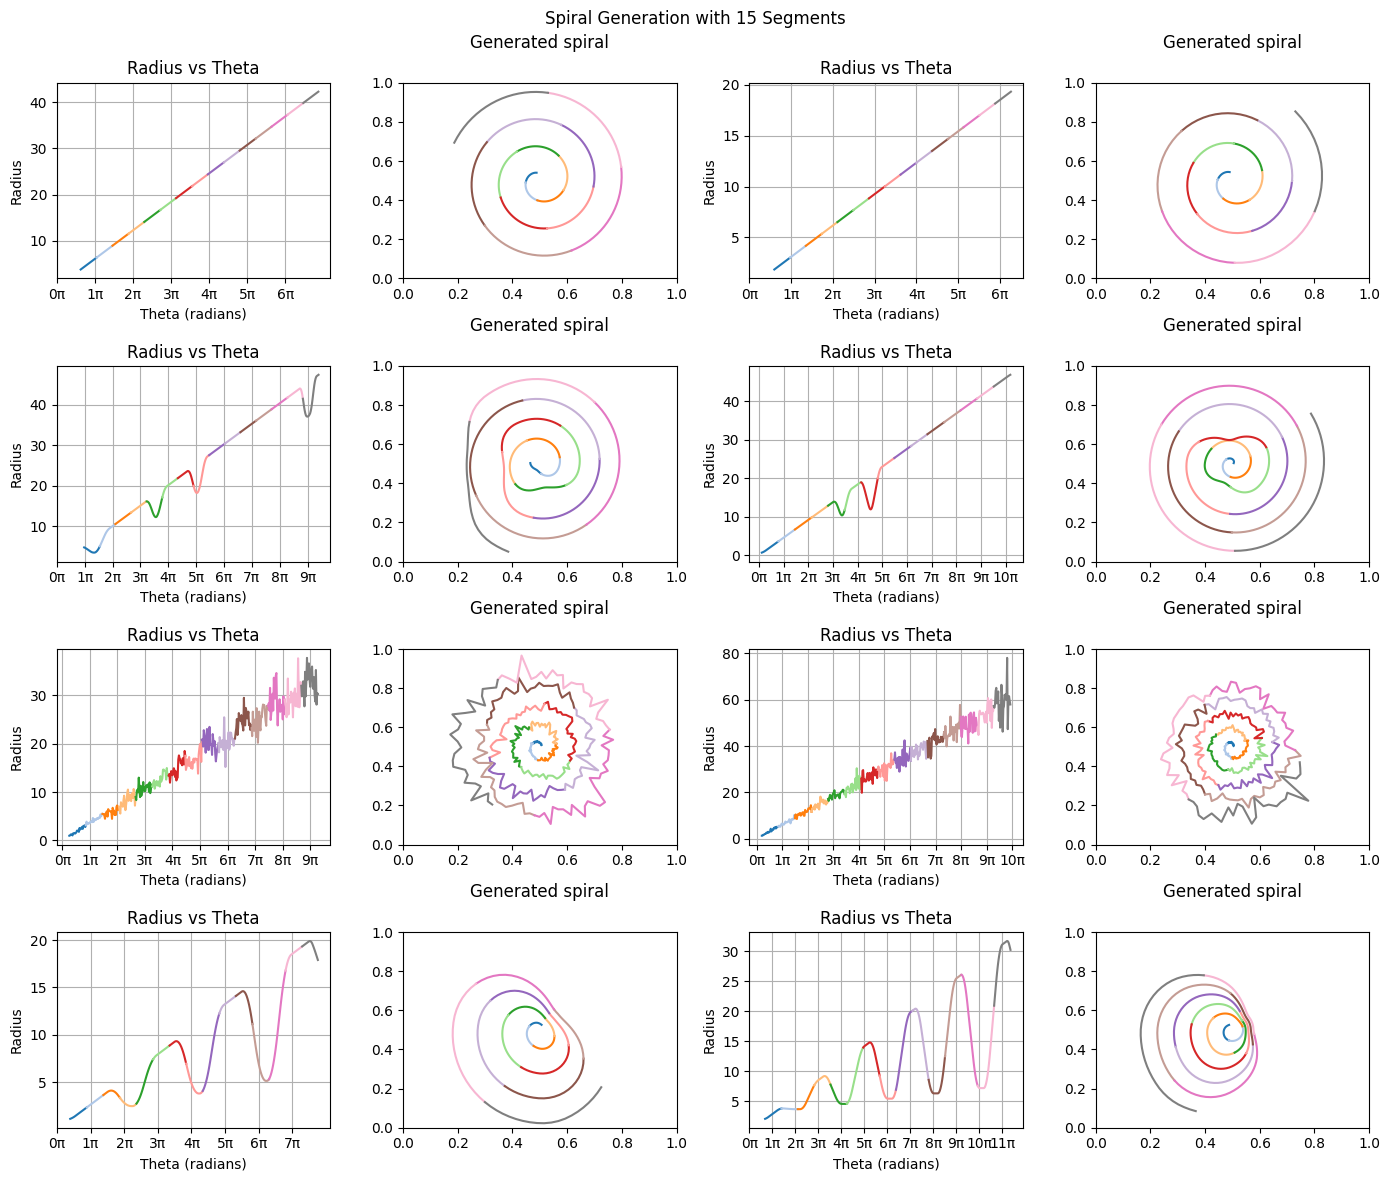

In [1033]:
fig, axs = plt.subplots(4, num2plot*2, figsize=(7*num2plot, 12))
axs = np.array(axs)  # ensure indexing works

for row in range(4):
    for col in range(num2plot):
        filepath = files[row * num2plot + col]
        data = pd.read_csv(filepath)
        theta = data['theta'].values
        r = data['r'].values

        col_ax = col * 2
        ax1 = axs[row, col_ax]  # Cartesian
        ax2 = fig.add_subplot(4, num2plot*2, row*num2plot*2 + col_ax + 2, projection='polar')  # Polar

        plot_segmented_spiral(
            gen_theta=theta,
            gen_r=r,
            num_segments=15,
            num_points=len(theta),
            axes=(ax1, ax2),
        )

plt.tight_layout()
plt.show()

### Addition of x and y coordinates

In [234]:
from pathlib import Path

# === CONFIGURATION ===
parent_dir = Path("./syn_data")
output_dir = parent_dir
output_dir.mkdir(exist_ok=True)

# Loop over all CSVs in all subfolders
for csv_path in parent_dir.glob("*/*.csv"):
    df = pd.read_csv(csv_path)
        
    theta = df['theta'].values
    r = df['r'].values

    # Compute Cartesian coordinates
    df['x'] = r * np.cos(theta)
    df['y'] = r * np.sin(theta)

    # Save result
    # Option A: overwrite
    df.to_csv(csv_path, index=False)

    print(f"Processed: {csv_path.name}")

print("✅ All spirals processed.")

Processed: archimedes_spiral_825.csv
Processed: archimedes_spiral_86.csv
Processed: archimedes_spiral_92.csv
Processed: archimedes_spiral_831.csv
Processed: archimedes_spiral_819.csv
Processed: archimedes_spiral_158.csv
Processed: archimedes_spiral_45.csv
Processed: archimedes_spiral_51.csv
Processed: archimedes_spiral_602.csv
Processed: archimedes_spiral_79.csv
Processed: archimedes_spiral_164.csv
Processed: archimedes_spiral_170.csv
Processed: archimedes_spiral_616.csv
Processed: archimedes_spiral_399.csv
Processed: archimedes_spiral_428.csv
Processed: archimedes_spiral_366.csv
Processed: archimedes_spiral_400.csv
Processed: archimedes_spiral_414.csv
Processed: archimedes_spiral_372.csv
Processed: archimedes_spiral_548.csv
Processed: archimedes_spiral_212.csv
Processed: archimedes_spiral_574.csv
Processed: archimedes_spiral_560.csv
Processed: archimedes_spiral_206.csv
Processed: archimedes_spiral_789.csv
Processed: archimedes_spiral_951.csv
Processed: archimedes_spiral_945.csv
Proces

## FFT and tightness rotation

In [160]:
## PARAMETERS
steps_per_rotation = 100
k_range = (0.5, 2.0)

n_ratio_range = (0.01, 0.02) # Ratio of n parameter for linear equation in terms of max radius
tightness_k_range = (0.4, 1.3)
tightness_width_ratio_range = (0.1, 0.14) # Ratio of width of tightness to max radius
max_k2k_ratio = 0.45  # Max ratio of tightness_k to original k
FLAT_PERCENTAGE = 0.3
theta_lb, theta_ub = 0, 12*np.pi

def tight_spiral(tightness_angle, steps_per_rotation=100):
    
    # Basic spiral parameters
    theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
    k = np.random.uniform(k_range[0], k_range[1])
    r = k * theta

    # Tightening parameters
    n_ratio = np.random.uniform(n_ratio_range[0], n_ratio_range[1])
    max_r = np.max(r)
    tightness_k = np.random.uniform(tightness_k_range[0], np.min([tightness_k_range[1], max_k2k_ratio*k]))
    tightness_width = np.random.uniform(tightness_width_ratio_range[0], tightness_width_ratio_range[1]) * max_r
    
    local_minimas_theta = []
    local_minimas_r = []
    minima_theta = tightness_angle
    while minima_theta < theta_ub + 2*np.pi:
        local_minimas_theta.append(minima_theta)
        local_minimas_r.append(tightness_k * minima_theta + n_ratio * max_r)
        minima_theta += 2*np.pi
    local_minimas_theta = np.array(local_minimas_theta)
    local_minimas_r = np.array(local_minimas_r)


    r_tightened = r.copy()
    r_tightened = apply_local_shaping(r_tightened, theta, local_minimas_theta, local_minimas_r, [], [], tightness_width, FLAT_PERCENTAGE)
    r_tightened = gaussian_filter(r_tightened, sigma=10.0, mode='nearest', radius=6)
    
    x = r_tightened * np.cos(theta)
    y = r_tightened * np.sin(theta)
    return theta, r_tightened, x, y

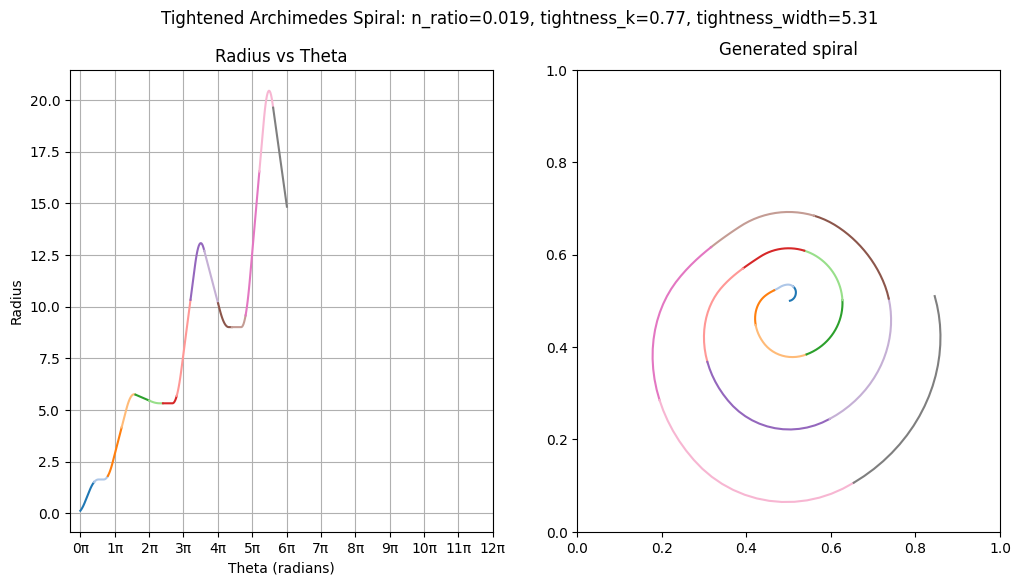

In [161]:
theta_tight, r_tight, _, _ = tight_spiral(tightness_angle=np.pi/2)
plot_segmented_spiral(
    gen_theta=theta_tight,
    gen_r=r_tight,
    num_segments=15,
    num_points=len(theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Tightened Archimedes Spiral: n_ratio={n_ratio:.3f}, tightness_k={tightness_k:.2f}, tightness_width={tightness_width:.2f}"
)

In [162]:
def plot_coeficients(Zs, names=None):
    N = len(Zs[0])
    num_comp = len(Zs)
    
    x = np.arange(N)
    _, axes = plt.subplots(num_comp, 1, figsize=(12, 5 * num_comp), sharex=True)
    if num_comp == 1: axes = [axes]
    
    vectors = []
    
    for i, ax in enumerate(axes):
        
        Z_real = Zs[i].real
        Z_imag = Zs[i].imag
        
        temp = np.concatenate((Z_real,Z_imag))
        
        vectors.append(temp)
        
        ax.bar(x, Z_real, color='royalblue', alpha=0.7, label='Real')
        ax.bar(x, Z_imag, color='darkorange', alpha=0.7, label='Imag', width=0.4)
        
        if names is not None:
            ax.set_title(f"Fourier coeficients for {names[i]}")
        else:
            ax.set_title(f"Fourier coeficients")
        ax.set_ylabel("Weight")
        ax.grid(True, axis='y', linestyle='--', alpha=0.4)
        ax.legend()

    dist = np.sqrt(np.sum([(x-y)**2 for x,y in zip(vectors[0],vectors[-1])]))
    # print(dist)
    
    
    axes[-1].set_xlabel("Feature index")
    plt.tight_layout()
    plt.show()

In [163]:
angle_linespace = np.linspace(0, 2*np.pi, 12, endpoint=False)

spirals_per_angle_FFT = {angle: [] for angle in angle_linespace}

for angle in angle_linespace:
    for _ in range(20):  # Generate 5 spirals per angle
        theta_tight, r_tight, x_tight, y_tight = tight_spiral(tightness_angle=angle, steps_per_rotation=30)
        N = len(x_tight)
        z = np.array([complex(x, y) for x, y in zip(x_tight, y_tight)])
        Z = np.fft.fft(z) / N        
        spirals_per_angle_FFT[angle].append(Z)

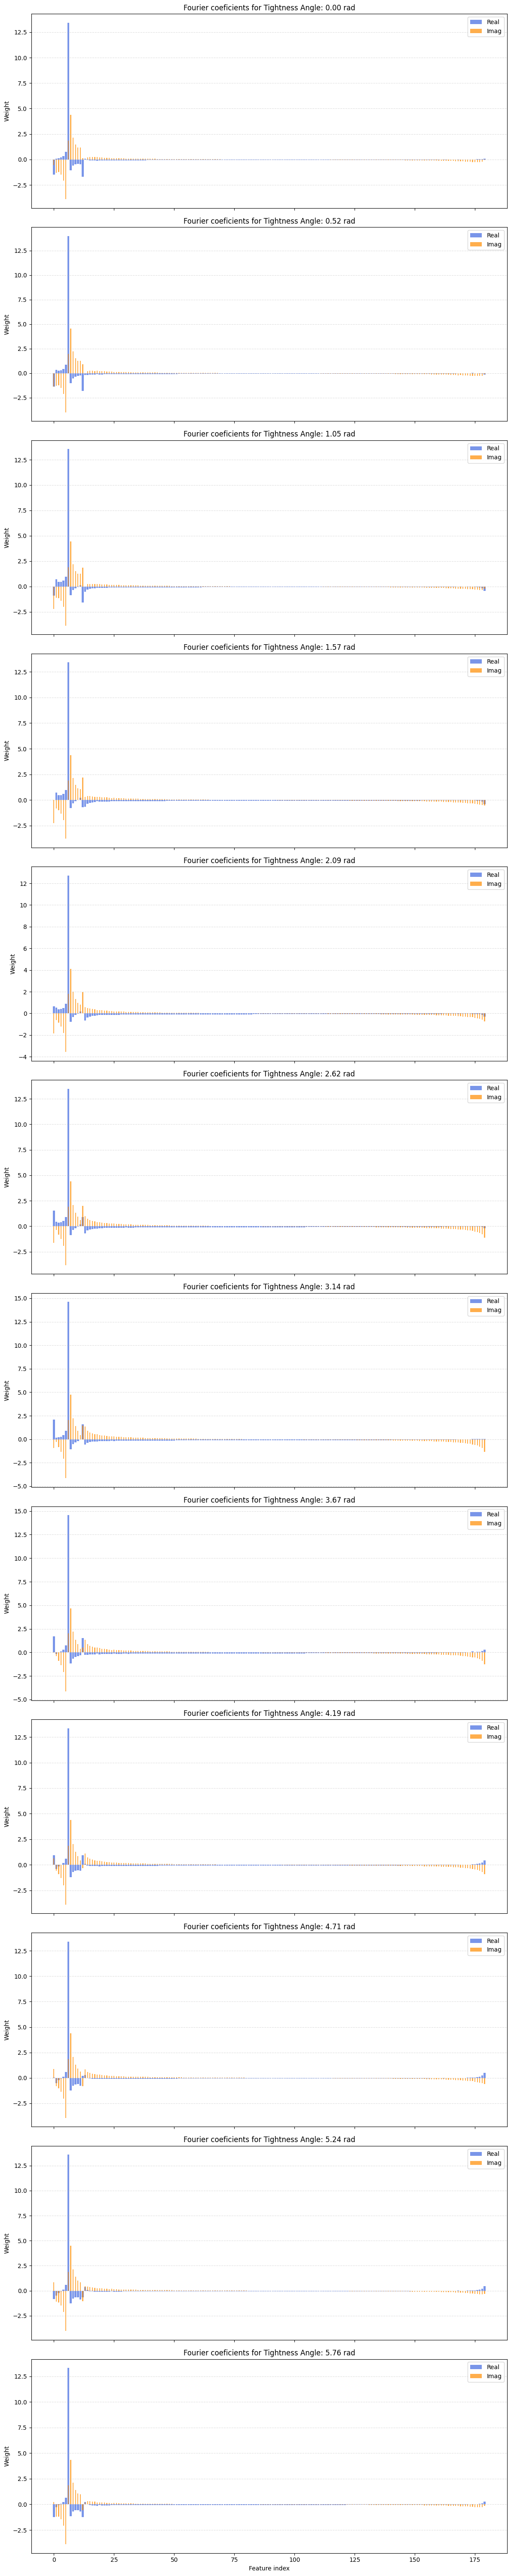

In [164]:
plot_coeficients(
    Zs=[np.mean(spirals_per_angle_FFT[angle], axis=0) for angle in angle_linespace],
    names=[f"Tightness Angle: {angle:.2f} rad" for angle in angle_linespace]
)

In [165]:
def plot_fft_means_by_angle(spirals_per_angle_FFT, cmap='tab20'):
    """
    Parameters
    ----------
    spirals_per_angle_FFT : dict[float -> list[np.ndarray]]
        Maps angle -> list of complex FFT arrays (same length N).
    rot_inv : bool
        If True, phase-align each spiral using its first significant harmonic
        before averaging (rotation invariance).
    cmap : str
        Matplotlib colormap name for distinguishing angles.
    """

    angles = sorted(spirals_per_angle_FFT.keys())
    if not angles:
        raise ValueError("Empty dictionary provided.")

    # Determine N and sanity-check all entries
    first_angle = angles[0]
    if not spirals_per_angle_FFT[first_angle]:
        raise ValueError(f"No FFT arrays for angle {first_angle}.")

    N = len(spirals_per_angle_FFT[first_angle][0])
    for a in angles:
        for Z in spirals_per_angle_FFT[a]:
            if len(Z) != N:
                raise ValueError(f"All FFT arrays must have same length N. Found mismatch at angle {a}.")

    # Prepare plotting
    x = np.arange(N)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(angles)))
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # For each angle: phase-align (optional), then mean over spirals
    for color, angle in zip(colors, angles):
        Z_list = spirals_per_angle_FFT[angle]
        aligned = []

        for Z in Z_list:
            Zi = np.asarray(Z, dtype=np.complex128)

            aligned.append(Zi)

        Z_stack = np.vstack(aligned)                 # shape: (num_spirals, N)
        Z_mean  = Z_stack.mean(axis=0)               # complex mean per coefficient

        # Plot: real and imaginary parts
        axes[0].plot(x, Z_mean.real, color=color, lw=1.8, label=f"{angle/np.pi:.2f}π")
        axes[1].plot(x, Z_mean.imag, color=color, lw=1.8, label=f"{angle/np.pi:.2f}π")

    # Styling
    axes[0].set_title("Mean FFT coefficients — Real part")
    axes[1].set_title("Mean FFT coefficients — Imag part")
    axes[1].set_xlabel("Coefficient index k")
    for ax in axes:
        ax.set_ylabel("Value")
        ax.grid(True, linestyle='--', alpha=0.35)
        ax.legend(title="Angle", bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

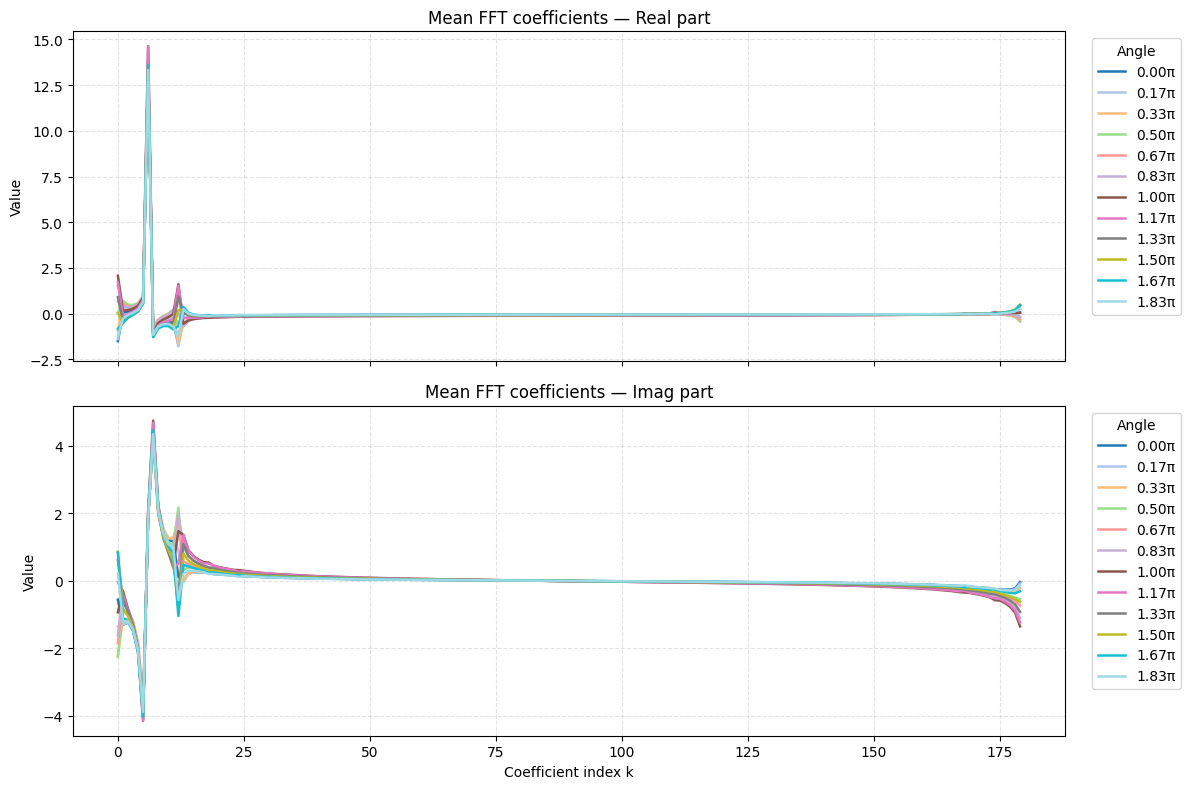

In [166]:
plot_fft_means_by_angle(spirals_per_angle_FFT, cmap='tab20')

In [167]:
def plot_fft_means_by_angle_bar(spirals_per_angle_FFT, alpha=0.55, cmap='tab20'):
    """
    Plot mean FFT coefficients per angle using barplots (real & imaginary).
    Each angle gets its own color and offset on the x-axis.

    Parameters
    ----------
    spirals_per_angle_FFT : dict[float -> list[np.ndarray]]
        angle -> list of FFT arrays
    rot_inv : bool
        Phase-align spirals (rotation invariance)
    alpha : float
        Bar opacity
    cmap : str
        Matplotlib colormap for angle colors
    """

    angles = sorted(spirals_per_angle_FFT.keys())
    num_angles = len(angles)

    # Get N from first FFT
    N = len(next(iter(spirals_per_angle_FFT.values()))[0])
    x = np.arange(N)

    # color map for angles
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, num_angles))

    # bar width (small because we overlay many angles)
    width = 0.8 / num_angles

    # Prepare figure
    fig, axes = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
    ax_real, ax_imag = axes

    # Loop angles
    for idx, (angle, color) in enumerate(zip(angles, colors)):
        Z_list = spirals_per_angle_FFT[angle]
        aligned = []

        # Phase alignment
        for Z in Z_list:
            Zi = np.asarray(Z, dtype=np.complex128)
            aligned.append(Zi)

        # Mean FFT across spirals at this angle
        Z_mean = np.vstack(aligned).mean(axis=0)

        # Offset bars left/right depending on angle index
        offset = (idx - num_angles / 2) * width

        # Bar plots
        ax_real.bar(x + offset, Z_mean.real, width=width, color=color,
                    alpha=alpha, label=f"{angle/np.pi:.2f}π")
        ax_imag.bar(x + offset, Z_mean.imag, width=width, color=color,
                    alpha=alpha, label=f"{angle/np.pi:.2f}π")

    # Titles & labels
    ax_real.set_title("Mean FFT coefficients — Real part")
    ax_imag.set_title("Mean FFT coefficients — Imag part")

    ax_imag.set_xlabel("Coefficient index k")
    ax_real.set_ylabel("Real value")
    ax_imag.set_ylabel("Imag value")

    # Grid
    for ax in axes:
        ax.grid(True, linestyle='--', alpha=0.35)

    # Combined legend
    handles, labels = ax_real.get_legend_handles_labels()
    fig.legend(handles, labels, title="Angle", bbox_to_anchor=(1.01, 1),
               loc='upper left')

    plt.tight_layout()
    plt.show()

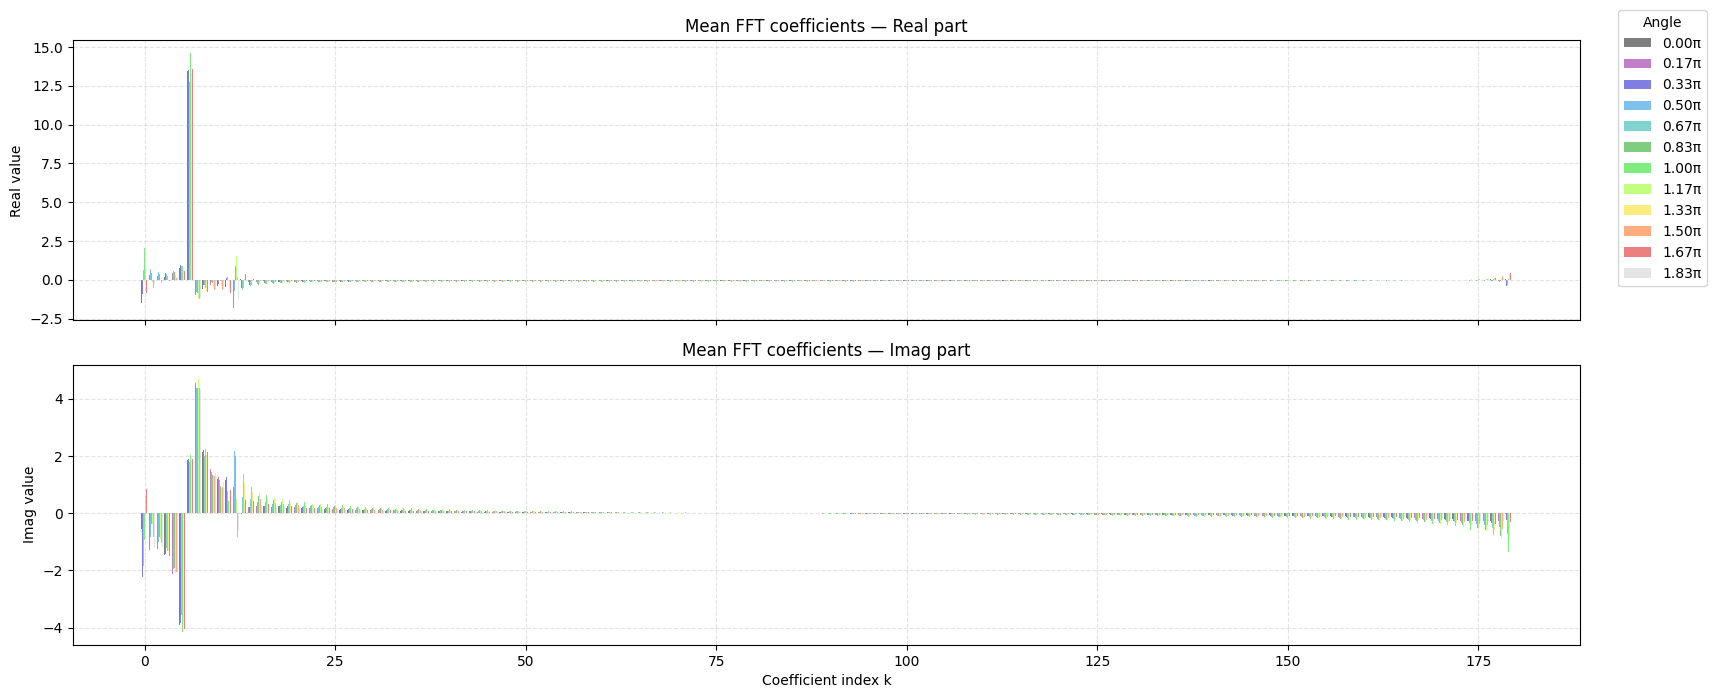

In [168]:
plot_fft_means_by_angle_bar(spirals_per_angle_FFT, alpha=0.5, cmap='nipy_spectral')

In [169]:
def plot_fft_spirals_two_angles(spirals_per_angle_FFT, angle1, angle2,
                                cmap='tab20', alpha=0.7):
    """
    Compare ALL FFT spirals for two angles in a 2x2 layout:
      Row 0: angle1  (Real | Imag)
      Row 1: angle2  (Real | Imag)

    Parameters
    ----------
    spirals_per_angle_FFT : dict[float -> list[np.ndarray]]
        Maps angle -> list of complex FFT arrays (same length N).
    angle1, angle2 : float
        Angles (keys in the dict) to compare.
    rot_inv : bool
        If True, phase-align each spiral using its first significant harmonic.
    cmap : str
        Matplotlib colormap name for distinguishing spirals (per angle).
    alpha : float
        Line opacity.
    """

    # --- basic checks ---
    for a in (angle1, angle2):
        if a not in spirals_per_angle_FFT:
            raise ValueError(f"Angle {a} not found in spirals_per_angle_FFT.")
        if not spirals_per_angle_FFT[a]:
            raise ValueError(f"No FFT arrays stored for angle {a}.")

    # assume consistent N across dict (you can tighten if needed)
    N = len(spirals_per_angle_FFT[angle1][0])
    for a in (angle1, angle2):
        for idx, Z in enumerate(spirals_per_angle_FFT[a]):
            if len(Z) != N:
                raise ValueError(
                    f"All FFT arrays must have same length N. "
                    f"Found mismatch for angle {a} at spiral {idx}."
                )

    x = np.arange(N)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
    # layout:
    # [0,0] angle1 real, [0,1] angle1 imag
    # [1,0] angle2 real, [1,1] angle2 imag

    def plot_angle(angle, row_idx):
        Z_list = spirals_per_angle_FFT[angle]
        num_spirals = len(Z_list)
        colors = plt.get_cmap(cmap)(np.linspace(0, 1, num_spirals))

        ax_real = axes[row_idx, 0]
        ax_imag = axes[row_idx, 1]

        for color, (s_idx, Z) in zip(colors, enumerate(Z_list)):
            Zi = np.asarray(Z, dtype=np.complex128)

            ax_real.plot(x, Zi.real, color=color, lw=1.1, alpha=alpha,
                         label=f"spiral {s_idx}")
            ax_imag.plot(x, Zi.imag, color=color, lw=1.1, alpha=alpha,
                         label=f"spiral {s_idx}")

        ax_real.set_title(f"Real part (angle={angle/np.pi:.2f}π)")
        ax_imag.set_title(f"Imag part (angle={angle/np.pi:.2f}π)")
        ax_real.set_ylabel("Value")
        ax_imag.set_ylabel("Value")

        ax_real.grid(True, linestyle='--', alpha=0.35)
        ax_imag.grid(True, linestyle='--', alpha=0.35)

        # Legend on imag subplot for this row
        # handles, labels = ax_imag.get_legend_handles_labels()
        # if handles:
        #     ax_imag.legend(handles, labels, title="Spiral index",
        #                    bbox_to_anchor=(1.02, 1), loc='upper left')

    # plot both angles
    plot_angle(angle1, row_idx=0)
    plot_angle(angle2, row_idx=1)

    axes[1, 0].set_xlabel("Coefficient index k")
    axes[1, 1].set_xlabel("Coefficient index k")
    
    # fig.set_title("FFT of tights spirals - two distinct rotations")

    plt.tight_layout()
    plt.show()

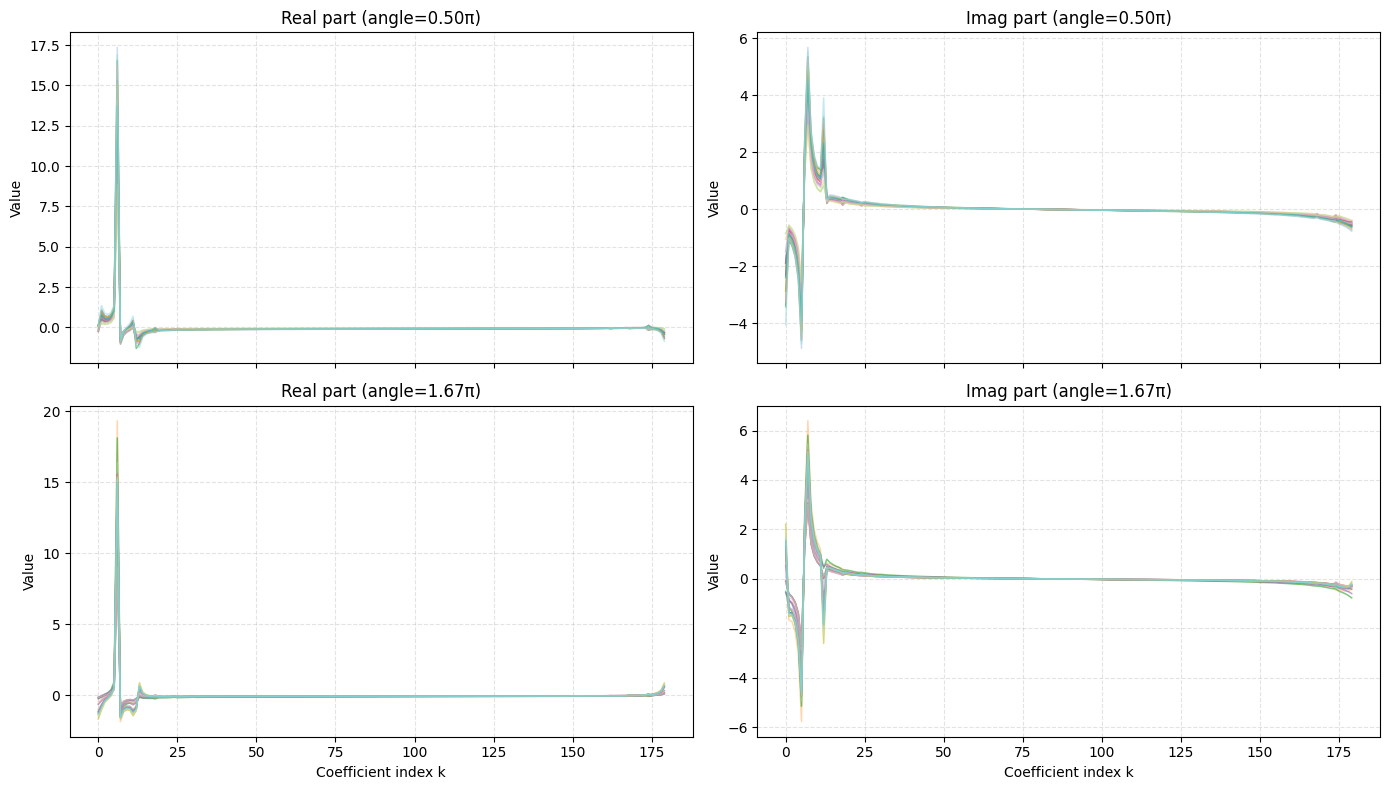

In [170]:
a1 = angle_linespace[3]
a2 = angle_linespace[10]
plot_fft_spirals_two_angles(spirals_per_angle_FFT, a1, a2, cmap='tab20', alpha=0.6)

### Rotation invariance - conviction: METHOD DOESN'T WORK!!

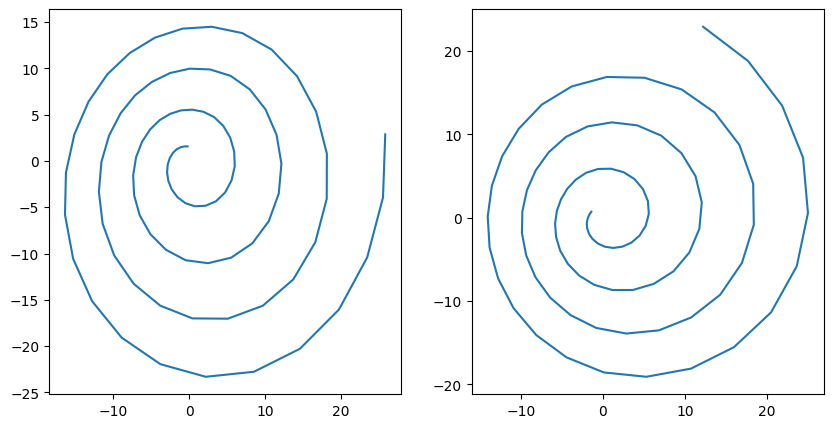

In [151]:
spiral = spirals_per_angle_FFT[0][10]
_, _, spiralx, spiraly = tight_spiral(3*np.pi/4, steps_per_rotation=30)
N = len(spiralx)
z = np.array([complex(x, y) for x, y in zip(spiralx, spiraly)])
spiral_fft = np.fft.fft(z) / N

Zi = np.asarray(spiral_fft, dtype=np.complex128)

nz = np.where(np.abs(Zi[1:]) > 1e-8)[0]
if nz.size > 0:
    k0 = int(nz[0] + 1)
    phase = np.angle(Zi[k0])
    Zi = Zi * np.exp(-1j * phase)

spiral_xy = inverse_fourier_descriptor_transform(spiral_fft)
spiral_ri_xy = inverse_fourier_descriptor_transform(Zi)

spiral_x, spiral_y = zip(*spiral_xy.values())
spiral_ri_x, spiral_ri_y = zip(*spiral_ri_xy.values())

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(spiral_x, spiral_y)
axes[1].plot(spiral_ri_x, spiral_ri_y)
plt.show()